# HW6: Support Vector Machines

In this exercise, you will be using support vector machines (SVMs) to build a spam classifier. Before starting on the programming exercise, we strongly recommend watching the video lectures and completing the review questions for the associated topics.

To get started with the exercise, you will need to download the starter code and unzip its contents to the directory where you wish to complete the exercise. If needed, use the cd command in Octave/MATLAB to change to this directory before starting this exercise.

You can also find instructions for installing Octave/MATLAB in the “Environment Setup Instructions” of the course website.

In [1]:
import itertools as it
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import scipy.misc
import scipy.optimize as op
import scipy.io
import random
from IPython.display import display, Math, Latex

# set path
import os
os.chdir('%s/courses/coursera_ml008/hw6' % os.getenv('DST'))
print(os.getcwd())

# printing options 
np.set_printoptions(linewidth=250)
np.set_printoptions(precision=3)

# plotting options
%matplotlib inline
plt.rc('font'  , size=18)
plt.rc('figure', figsize=(10, 8))
plt.rc('axes'  , labelsize=22)
plt.rc('legend', fontsize=16)
plt.rc('figure', figsize=(10, 8))

C:\Users\J28976\Documents\Development\dst\courses\coursera_ml008\hw6


## 1 Support Vector Machines

In the first half of this exercise, you will be using support vector machines (SVMs) with various example 2D datasets. Experimenting with these datasets will help you gain an intuition of how SVMs work and how to use a Gaussian kernel with SVMs. In the next half of the exercise, you will be using support vector machines to build a spam classifier.

The provided script, ex6.m, will help you step through the first half of the exercise.

### 1.1 Example Dataset 1


We will begin by with a 2D example dataset which can be separated by a linear boundary. The script ex6.m will plot the training data (Figure 1). In this dataset, the positions of the positive examples (indicated with +) and the negative examples (indicated with o) suggest a natural separation indicated by the gap. However, notice that there is an outlier positive example + on the far left at about (0.1, 4.1). As part of this exercise, you will also see how this outlier affects the SVM decision boundary.

<img src="fig1.png" width=500/>

In this part of the exercise, you will try using different values of the $C$ parameter with SVMs. Informally, the $C$ parameter is a positive value that controls the penalty for misclassified training examples. A large $C$ parameter tells the SVM to try to classify all the examples correctly. $C$ plays a role similar to 1, where $\lambda$ is the regularization parameter that we were using $\lambda$ previously for logistic regression.

<img src="fig2.png" width=700/>
<img src="fig3.png" width=750/>

The next part in ex6.m will run the SVM training (with $C = 1$) using ￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼SVM software that we have included with the starter code, svmTrain.m When $C = 1$, you should find that the SVM puts the decision boundary in the gap between the two datasets and misclassifies the data point on the far left (Figure 2).

Your task is to try different values of $C$ on this dataset. Specifically, you should change the value of $C$ in the script to $C = 100$ and run the SVM training again. When $C = 100$, you should find that the SVM now classifies every single example correctly, but has a decision boundary that does not appear to be a natural fit for the data (Figure 3).

In [2]:
ex6data1 = scipy.io.loadmat('ex6data1.mat')
X = np.asarray(ex6data1['X'])
y = np.asarray(ex6data1['y'].ravel())
X.shape, y.shape

((51L, 2L), (51L,))

In [3]:
def display_data(X, y, boundary=None):
    pos = y==1
    neg = np.logical_not(pos)
    plt.scatter(X[pos,0], X[pos,1], c='k', marker='+', s=50)
    plt.scatter(X[neg,0], X[neg,1], c='y', marker='o', s=50)
    plt.axis([0, 5, 1, 5])
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.legend(['positive', 'negative'], loc='lower left')
    
    if boundary is not None:
        xp, yp = boundary
        plt.plot(xp, yp, 'b-')
    plt.show()
 

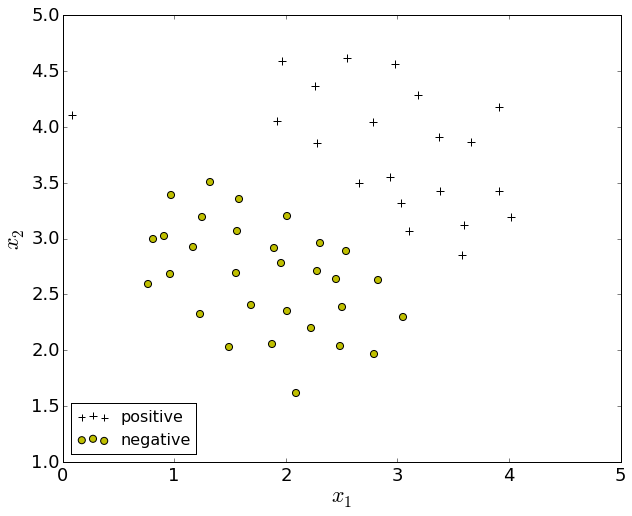

In [4]:
display_data(X, y)

#### fit using SVM

In [5]:
# Import datasets, classifiers and performance metrics
from sklearn import svm

In [6]:
classifier = svm.SVC(C=1.0, kernel='linear')
classifier

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [7]:
classifier.fit(X, y)
classifier

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [8]:
def get_boundary(classifier):
    w = classifier.dual_coef_.dot(classifier.support_vectors_).flatten()
    xp = np.linspace(0, 5, 100)
    yp = (-w[0]*xp - classifier.intercept_)/w[1]
    return xp, yp    

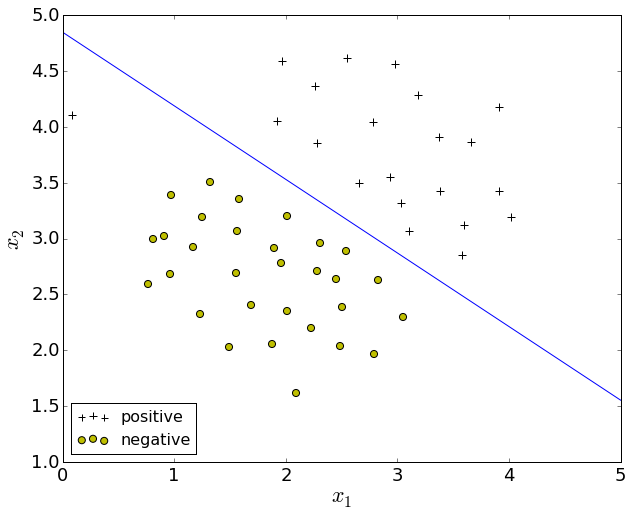

In [9]:
display_data(X, y, get_boundary(classifier))

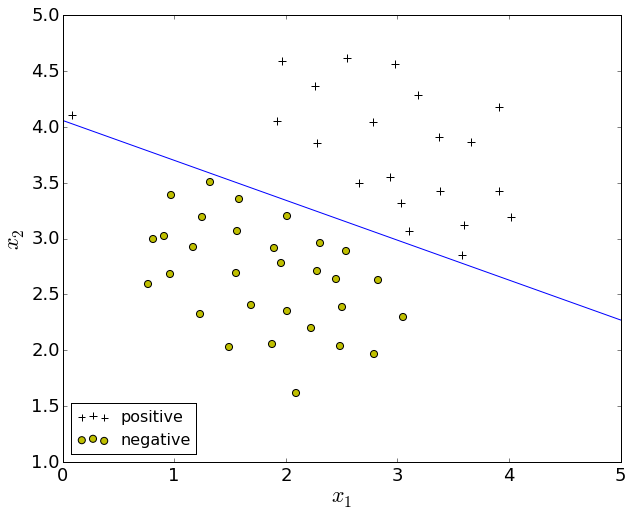

In [10]:
classifier = svm.SVC(C=100.0, kernel='linear')
classifier.fit(X, y)
display_data(X, y, get_boundary(classifier))

### 1.2 SVM with Gaussian Kernels

In this part of the exercise, you will be using SVMs to do non-linear classification. In particular, you will be using SVMs with Gaussian kernels on datasets that are not linearly separable.

#### 1.2.1 Gaussian Kernel

To finnd non-linear decision boundaries with the SVM, we need to first implement a Gaussian kernel. You can think of the Gaussian kernel as a similarity function that measures the "distance" between a pair of examples, $(x^{(i)}, x^{(j)})$. The Gaussian kernel is also parameterized by a bandwidth parameter, $\sigma$, which determines how fast the similarity metric decreases (to 0) as the examples are further apart.

You should now complete the code in `gaussianKernel.m` to compute the Gaussian kernel between two examples, $(x^{(i)}, x^{(j)})$. The Gaussian kernel function is defined as:

\begin{align}
K_{gaussian}(x^{(i)}, x^{(j)}) 
= \exp\left( -\frac{\|x^{(i)} - x^{(j)}\|^2}{2\sigma^2}\right)
= \exp\left( -\frac{\sum^n_{k=1} \left(x_k^{(i)} - x_k^{(j)}\right)^2}{2\sigma^2}\right)
\end{align}

Once you've completed the function `gaussianKernel.m`, the script `ex6.m` will test your kernel function on two provided examples and you should expect to see a value of 0.324652.

In [29]:
def gaussian_kernel(xi, xj, sigma):
#     print(xi, xj)
    xi    = np.asarray(xi, dtype=np.float)
    xj    = np.asarray(xj, dtype=np.float)
    assert xi.shape==xj.shape, "shapes must be the same"
    
    sigma = float(sigma)
#     return np.exp(-np.sum((xi-xj)**2, axis=1)/(2*sigma**2))
    return np.exp(-np.sum((xi-xj)**2)/(2*sigma**2))

In [30]:
x1    = np.array([1, 2, 1]).reshape(3,1)
x2    = np.array([0, 4, -1]).reshape(3,1)
sigma = 2
gaussian_kernel(x1, x2, sigma)

0.32465246735834974

In [32]:
gaussian_kernel(X, X, sigma)

1.0

#### 1.2.1 Example Dataset 2

The next part in `ex6.m` will load and plot dataset 2 (Figure 4). From the figure, you can observe that there is no linear decision boundary that separates the positive and negative examples for this dataset. However, by using the Gaussian kernel with the SVM, you will be able to learn a non-linear decision boundary that can perform reasonably well for the dataset.

In [25]:
ex6data2 = scipy.io.loadmat('ex6data2.mat')
X = np.asarray(ex6data2['X'])
y = np.asarray(ex6data2['y'].ravel())
X.shape, y.shape

((863L, 2L), (863L,))

In [82]:
def display_data(X, y, boundary=None):
    pos = y==1
    neg = np.logical_not(pos)
    plt.scatter(X[pos,0], X[pos,1], c='k', marker='+', s=50)
    plt.scatter(X[neg,0], X[neg,1], c='y', marker='o', s=50)
    plt.axis([0, 1, 0.4, 1])
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.legend(['positive', 'negative'], loc='lower left')
    
#     if boundary is not None:
#         xp, yp = boundary
#         plt.plot(xp, yp, 'b-')
    plt.show()

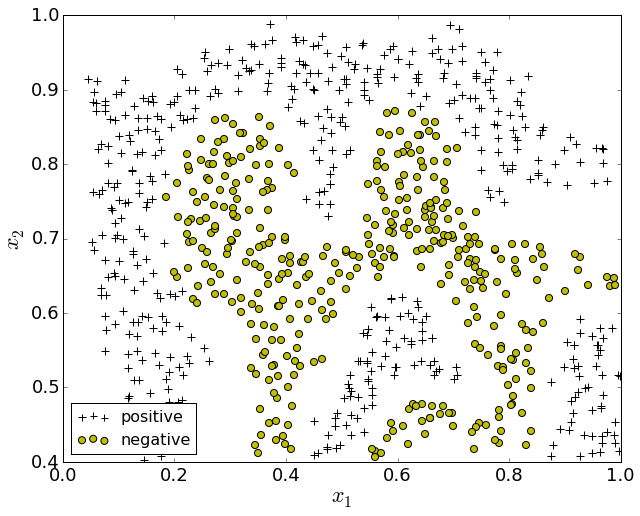

In [83]:
display_data(X, y)

If you have correctly implemented the Gaussian kernel function, `ex6.m` will proceed to train the SVM with the Gaussian kernel on this dataset. Figure 5 shows the decision boundary found by the SVM with a Gaussian kernel. The decision boundary is able to separate most of the positive and negative examples correctly and follows the contours of the dataset well.

In [92]:
gaus_svm = svm.SVC(C=1, kernel=lambda xi,xj : gaussian_kernel(xi, xj, sigma=0.1))
gaus_svm

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel=<function <lambda> at 0x0000000017DC0898>, max_iter=-1,
  probability=False, random_state=None, shrinking=True, tol=0.001,
  verbose=False)

In [124]:
sigma    = 0.01
C        = 1.0
gaus_svm = svm.SVC(C=C, kernel='rbf', gamma=1.0/sigma)
gaus_svm

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3,
  gamma=100.0, kernel='rbf', max_iter=-1, probability=False,
  random_state=None, shrinking=True, tol=0.001, verbose=False)

In [125]:
gaus_svm.fit(X, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3,
  gamma=100.0, kernel='rbf', max_iter=-1, probability=False,
  random_state=None, shrinking=True, tol=0.001, verbose=False)

In [121]:
def get_boundary(gaus_svm):
    x1plot = np.linspace(0, 1, 100)
    x2plot = np.linspace(0, 1, 100)
    X1, X2 = np.meshgrid(x1plot, x2plot)
    vals   = np.zeros_like(X1)
    for i in np.arange(X1.shape[1]):
        Xi_grid    = np.c_[X1[:,i], X2[:,i]]
        vals[:, i] = gaus_svm.predict(Xi_grid)
    
    return X1, X2, vals

In [122]:
def display_data(X, y, boundary=None):
    pos = y==1
    neg = np.logical_not(pos)
    plt.scatter(X[pos,0], X[pos,1], c='k', marker='+', s=50)
    plt.scatter(X[neg,0], X[neg,1], c='y', marker='o', s=50)
    plt.axis([0, 1, 0.4, 1])
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.legend(['positive', 'negative'], loc='lower left')
    
    if boundary is not None:
        X1, X2, vals = boundary
        plt.contour( X1, X2, vals, colors='blue' )

    plt.show()

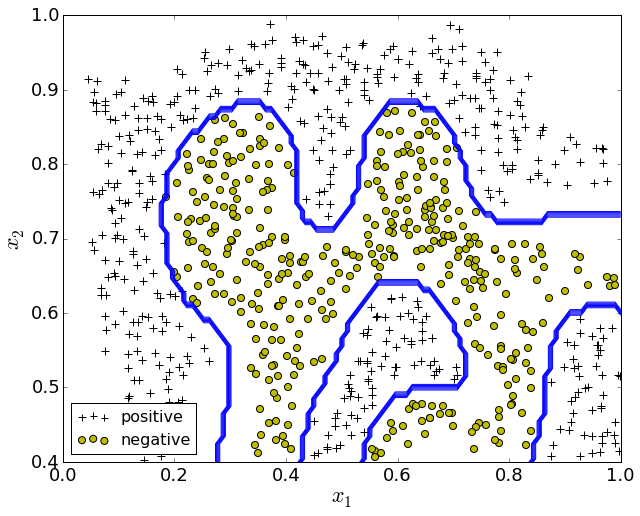

In [126]:
display_data(X, y, get_boundary(gaus_svm))

Figure 5 shows the decision boundary found by the SVM with a Gaussian kernel. The decision boundary is able to separate most of the positive and negative examples correctly and follows the contours of the dataset well. 

#### trying my own kernal (not working...)

In [37]:
# sigma    = 0.01
# C        = 1.0

# def gaussian_kernel_wrapper(xi, xj):
#     return gaussian_kernel(xi, xj, sigma=sigma)

In [38]:
# gaussian_kernel_wrapper(X, X)

In [39]:
# gaus_svm = svm.SVC(C=C, kernel=gaussian_kernel_wrapper)
# gaus_svm.fit(X, y)

#### 1.2.3 Example Dataset 3

In this part of the exercise, you will gain more practical skills on how to use a SVM with a Gaussian kernel. The next part of `ex6.m` will load and display a third dataset (Figure 6). You will be using the SVM with the Gaussian kernel with this dataset.

